# Grammian Angular Difference Field (GADF)

In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, 
                                    NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

analyte_name = 725

In [ ]:
# Only samples with spectra
#path = Path('/root/kssl-mirs-v2'); path.ls()
path = Path('../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|███████████████████████████████████████████████████████| 46305/46305 [00:01<00:00, 29135.84it/s]

n samples: 46251


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
paths = [p for p in paths if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

n samples: 44565


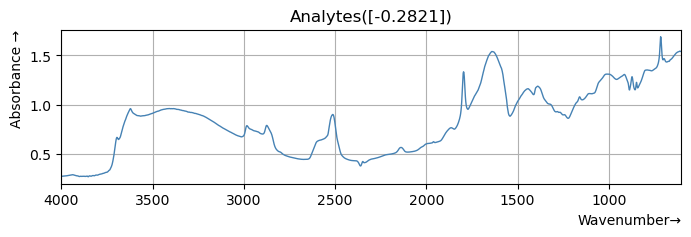

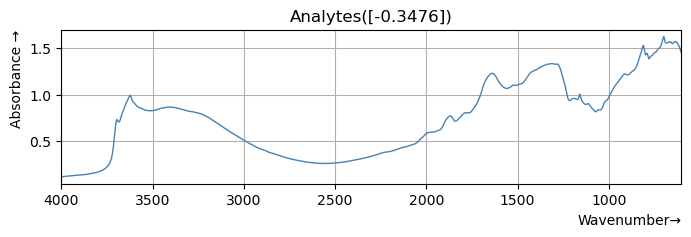

In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[AvgTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=32)
dls.show_batch(max_n=2)

In [ ]:
def rescale(x, neg=True):
    m, M = x.min(), x.max()
    return ((x - M) + (x - m)) / (M - m) if neg else (x - m) / (M - m)

In [ ]:
def plot(x):
    wn = np.arange(4000, 600, -2)
    fig, ax = plt.subplots(figsize=(8,2))
    ax.set_xlim(np.max(wn), np.min(wn))
    ax.set(xlabel='Wavenumber', ylabel='Absorbance')
    ax.set_axisbelow(True)
    ax.grid(True, which='both')
    _ = ax.plot(wn, x, lw=1)

In [ ]:
x0 = dls.one_batch()[0][28].numpy().squeeze()

In [ ]:
# Polar coordinate encoding
phi = np.arccos(rescale(x0))
r = np.arange(1, len(x0)+1) / len(x0)

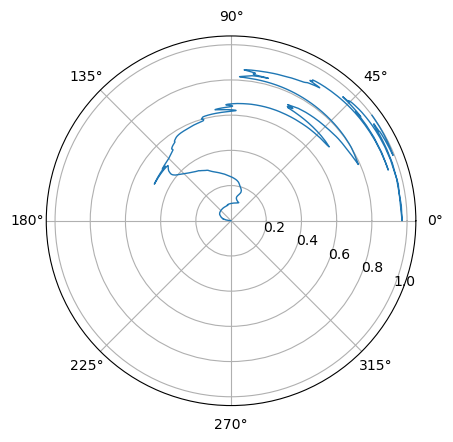

In [ ]:
# Ref: https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, r, lw=1)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

In [ ]:
phi

array([3.1415925 , 3.1091068 , 3.0962534 , ..., 0.58785486, 0.6054612 ,
       0.621959  ], dtype=float32)

In [ ]:
np.sin(phi[1] - phi[3])

0.023256112

In [ ]:
#X = phi.reshape(-1, 1); X.shape # col vector
X = rescale(x0).reshape(1, -1); X.shape

(1, 1700)

In [ ]:
def my_gadf(x):
    X, I = rescale(x).reshape(1, -1), np.ones((1, len(x)))
    alpha = np.sqrt(I - np.square(X))
    return (np.dot(alpha.T, X) - np.dot(X.T, alpha))

my_gadf(x0)[:4, :4]

array([[ 0.        ,  0.03573722,  0.04899143,  0.05926133],
       [-0.03573722,  0.        ,  0.01326583,  0.02354907],
       [-0.04899143, -0.01326583,  0.        ,  0.01028485],
       [-0.05926133, -0.02354907, -0.01028485,  0.        ]])

In [ ]:
smp_id = 4
x_demo = dls.one_batch()[0][smp_id].numpy().squeeze()

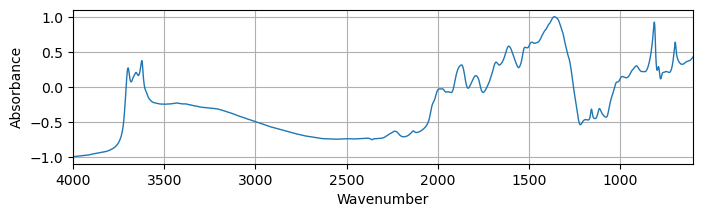

In [ ]:
plot(rescale(x_demo))

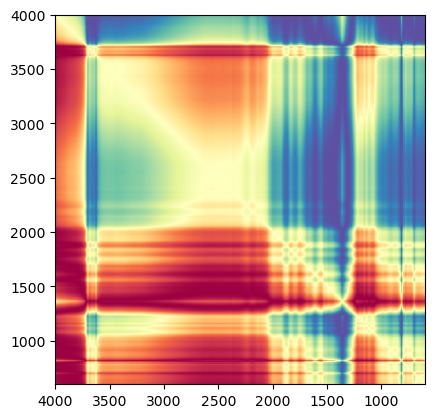

In [ ]:
plt.imshow(my_gadf(x_demo), cmap='Spectral', origin='upper', extent=[4000,600,600,4000]);

In [ ]:
# Resize to CxHxW
my_gadf(x0)

array([[ 0.        ,  0.03247988,  0.04532344, ...,  0.55457729,
         0.56914134,  0.58262844],
       [-0.03247988,  0.        ,  0.01285303, ...,  0.58131224,
         0.59554729,  0.60871869],
       [-0.04532344, -0.01285303,  0.        , ...,  0.59172248,
         0.60582319,  0.61886582],
       ...,
       [-0.55457729, -0.58131224, -0.59172248, ...,  0.        ,
        -0.01760538, -0.0340975 ],
       [-0.56914134, -0.59554729, -0.60582319, ...,  0.01760538,
         0.        , -0.01649707],
       [-0.58262844, -0.60871869, -0.61886582, ...,  0.0340975 ,
         0.01649707,  0.        ]])

In [ ]:
X_gadf[0, :4, :4]

array([[ 0.        ,  0.02921838,  0.04028021,  0.04886477],
       [-0.02921838,  0.        ,  0.01106834,  0.01966043],
       [-0.04028021, -0.01106834,  0.        ,  0.00859302],
       [-0.04886477, -0.01966043, -0.00859302,  0.        ]])

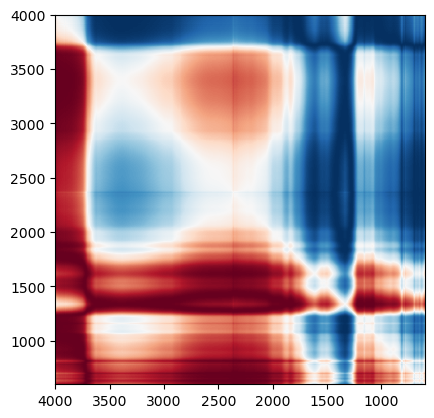

In [ ]:
plt.imshow(my_gadf(x0), cmap='RdBu', origin='upper', extent=[4000,600,600,4000]);

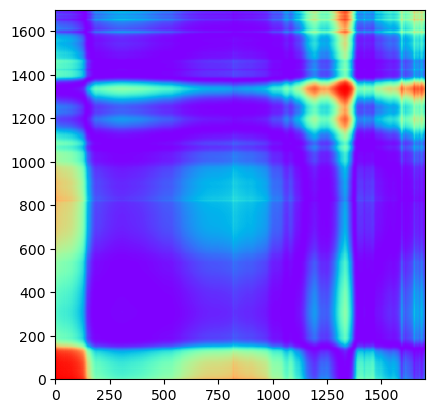

In [ ]:
# cos(φi + φj)
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(rescale(x0).reshape(1,-1))
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower');

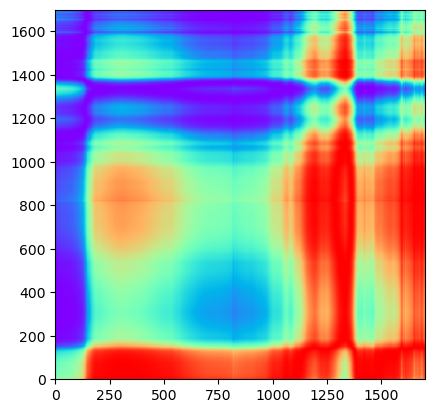

In [ ]:
# [sin(φi − φj)]
gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(rescale(x0).reshape(1,-1))
plt.imshow(X_gadf[0], cmap='rainbow', origin='lower');

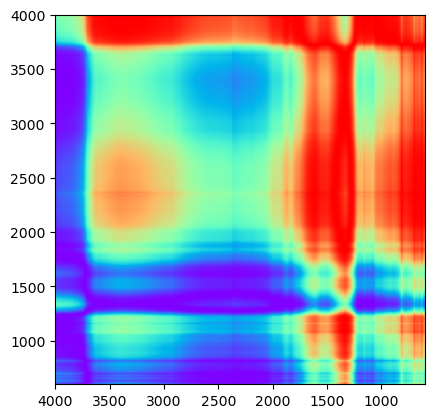

In [ ]:
plt.imshow(my_gadf(x0), cmap='rainbow', origin='upper', extent=[4000,600,600,4000]);

## Demo

Useful resources:
- https://shorturl.at/dwAY9
- https://arxiv.org/pdf/1506.00327.pdf

In [ ]:
from pyts.image import GramianAngularField
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Create a toy time series using the sine function
# 1000 points between 0 and 4π
time_points = np.linspace(0, 4 * np.pi, 1000)

In [ ]:
x = np.sin(time_points)

In [ ]:
X = np.array([x])

In [ ]:
# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

In [ ]:
X_gadf.shape

(1, 1000, 1000)

<matplotlib.colorbar.Colorbar>

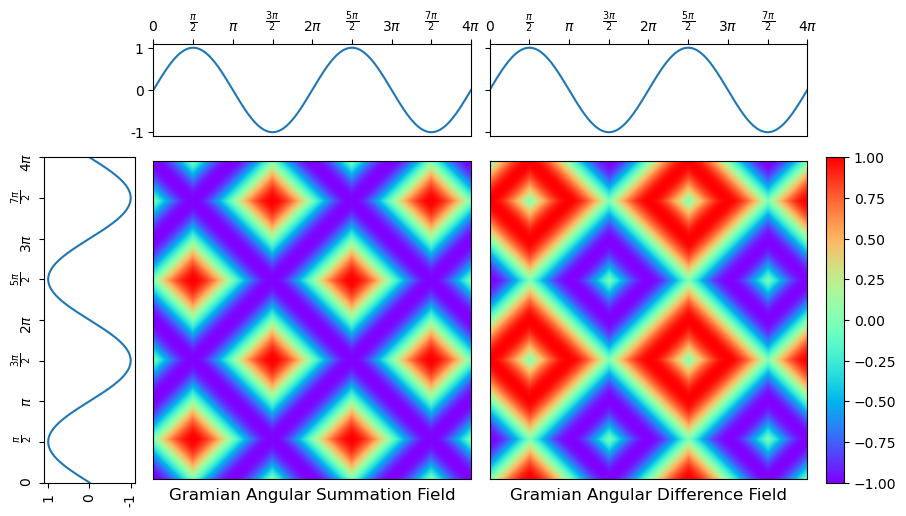

In [ ]:
# Plot the time series and its recurrence plot
width_ratios = (2, 7, 7, 0.4)
height_ratios = (2, 7)
width = 10
height = width * sum(height_ratios) / sum(width_ratios)
fig = plt.figure(figsize=(width, height))
gs = fig.add_gridspec(2, 4,  width_ratios=width_ratios,
                      height_ratios=height_ratios,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 4 * np.pi, 9)
time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
                   r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
                   r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
value_ticks = [-1, 0, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.set_ylim((0, 4 * np.pi))
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top1 = fig.add_subplot(gs[0, 1])
ax_top2 = fig.add_subplot(gs[0, 2])
for ax in (ax_top1, ax_top2):
    ax.plot(time_points, x)
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_ticklabels)
    ax.set_yticks(value_ticks)
    ax.xaxis.tick_top()
    ax.set_xlim((0, 4 * np.pi))
ax_top1.set_yticklabels(value_ticks)
ax_top2.set_yticklabels([])

# Plot the Gramian angular fields on the bottom right
ax_gasf = fig.add_subplot(gs[1, 1])
ax_gasf.imshow(X_gasf[0], cmap='rainbow', origin='lower',
               extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_gasf.set_xticks([])
ax_gasf.set_yticks([])
ax_gasf.set_title('Gramian Angular Summation Field', y=-0.09)

ax_gadf = fig.add_subplot(gs[1, 2])
im = ax_gadf.imshow(X_gadf[0], cmap='rainbow', origin='lower',
                    extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_gadf.set_xticks([])
ax_gadf.set_yticks([])
ax_gadf.set_title('Gramian Angular Difference Field', y=-0.09)

# Add colorbar
ax_cbar = fig.add_subplot(gs[1, 3])
fig.colorbar(im, cax=ax_cbar)